## <center>Assignment</center>

In this assignment, a dataset called Playground dataset will be used. This data includes four competitors and their (x, y) coordinations while they doing some exercise in the playground. The dataset can be downloaded [here](https://drive.google.com/drive/folders/1ZrBQ66U3PwH1hMrkiyJvG4vZW7SreTrW?usp=sharing).

### Goal

Train models using any methods you have learned so far to achieve best accuracy on the testing data. You can plot the train.csv and try to ensemble models that performs well on different competitors.

### Read this note carefully

- Submit to eeclass with your code file `Lab08_{student_id}.ipynb`. The notebook should contain
    1. Your code and accuracy by all the models you have tried, which will at least include voting, bagging, and boosting models
    2. Use Gridsearch to fine-tune your results. In particular, for base learner of adaboost, we hope you can try decision stump (decision tree with depth 1) and decision tree with higher depths
    3. Try to evaluate and summarize the results
- Deadline: **2024-01-07 (Sun) 23:59**
- Please make sure that we can rerun your code
- Please keep all the models you have tried in your ipynb

The following is example code to load and plot the training data

In [1]:
# inline plotting instead of popping out
%matplotlib inline

# python 3.9.6
import os, itertools, csv

from IPython.display import Image
from IPython.display import display

# numpy  1.26.0
import numpy as np

# pandas  2.1.1
import pandas as pd

# scikit-learn  1.3.1
from sklearn import datasets
load_iris = datasets.load_iris
make_moons = datasets.make_moons
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# matplotlib  3.8.0
import matplotlib.pyplot as plt

# load utility classes/functions e.g., plot_decision_regions()
import urllib.request
urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/04-1_Perceptron_Adaline/lab04lib.py", "lab04lib.py")
from lab04lib import *

# Make output directory
if not os.path.exists("output/") : os.mkdir("output/")
    
import warnings
warnings.filterwarnings("ignore")

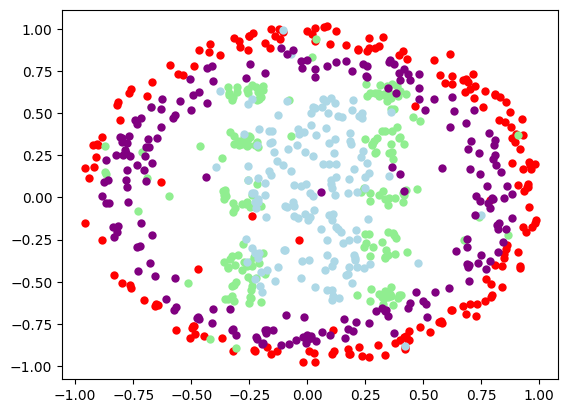

In [2]:
file = open('./train.csv', encoding='utf-8')
reader = csv.reader(file)
next(reader)
X = np.ndarray((0, 2))
y = np.ndarray((0,))
y_mapping = {'Bob': 0, 'Kate': 1, 'Mark': 2, 'Sue': 3}
i = 0
for row in reader:
    i += 1
    X = np.vstack((X, np.array(row[0:2])))
    y = np.append(y, y_mapping[row[2]])
X = X.astype(float)
y = y.astype(float)
file.close()

plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Bob', c='red', linewidths=0)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Kate', c='lightgreen', linewidths=0)
plt.scatter(
    X[y == 2, 0], X[y == 2, 1], label='Mark', c='lightblue', linewidths=0)
plt.scatter(X[y == 3, 0], X[y == 3, 1], label='Sue', c='purple', linewidths=0)

### Voting

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

dt =  DecisionTreeClassifier(max_depth=None)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print('[Decition Tree]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Test Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))

knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('[KNN]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Test Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))

svc = SVC(kernel='rbf', random_state=0, gamma=0.2, C=10.0, probability=True)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print('[SVC]')
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Test Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))

print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    voting = VotingClassifier(estimators=[('dt', dt), ('knn', knn), ('svc', svc)], 
                           voting='soft', weights=[a,b,c])
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    scores = accuracy_score(y_test, y_pred)
    print('%s: %.2f' % ((a, b, c), scores))
    if best_score < scores.mean():
        best_vt, best_w, best_score = voting, (a, b, c), scores.mean()

print('\nBest Test Accuracy %s: %.3f' % (best_w, best_score))

[Decition Tree]
Misclassified samples: 39
Test Accuracy: 0.74

[KNN]
Misclassified samples: 36
Test Accuracy: 0.76

[SVC]
Misclassified samples: 33
Test Accuracy: 0.78

[Voting]
(0, 1, 2): 0.82
(0, 2, 1): 0.79


(1, 0, 2): 0.78
(1, 2, 0): 0.79
(2, 0, 1): 0.75
(2, 1, 0): 0.76

Best Test Accuracy (0, 1, 2): 0.824


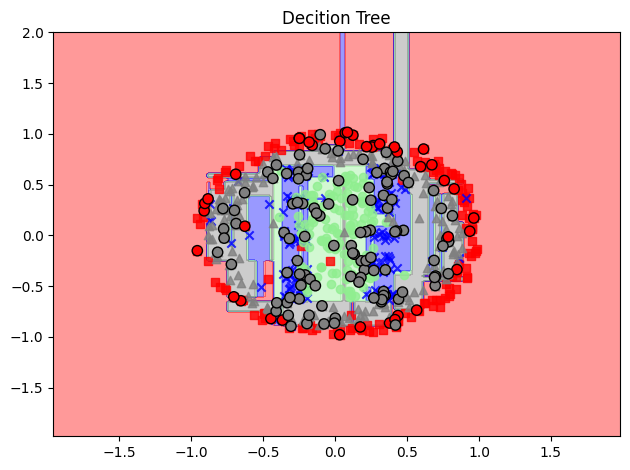

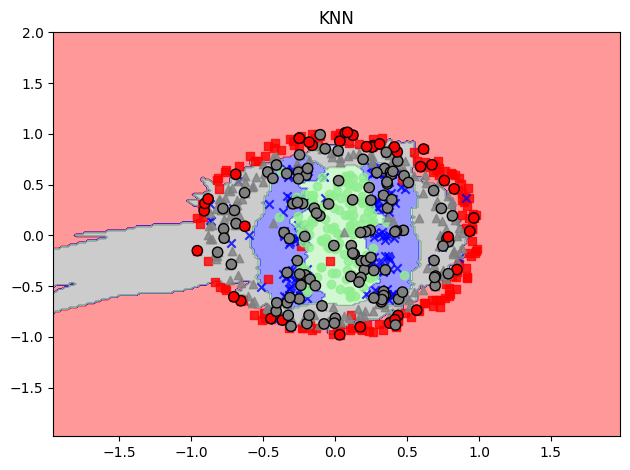

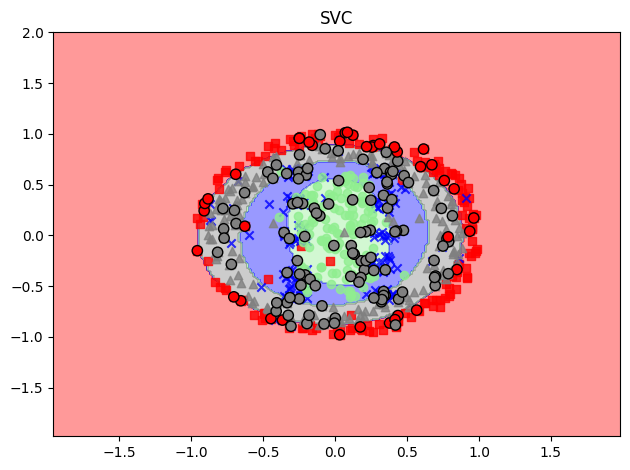

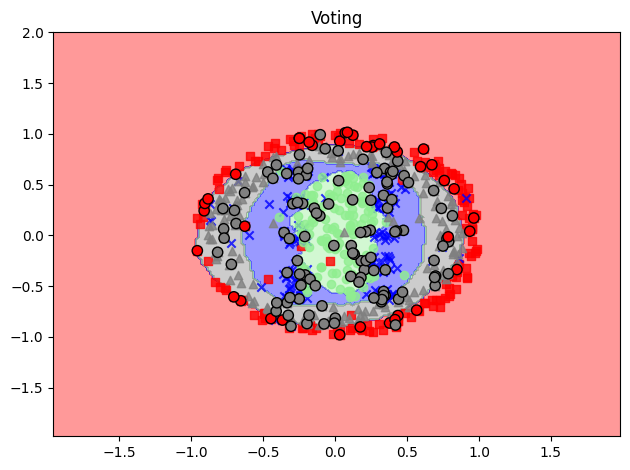

In [4]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=dt,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decition Tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=knn,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=svc,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('SVC')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=best_vt,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.show()


### Bagging

In [5]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=0)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)

# single DecisionTree
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (tree_train, tree_test))
# Bagging
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] Train Accuracy = %.3f, Test Accuracy = %.3f' % (bag_train, bag_test))

[DecisionTree] Train Accuracy = 1.000, Test Accuracy = 0.750



[Bagging] Train Accuracy = 0.993, Test Accuracy = 0.804


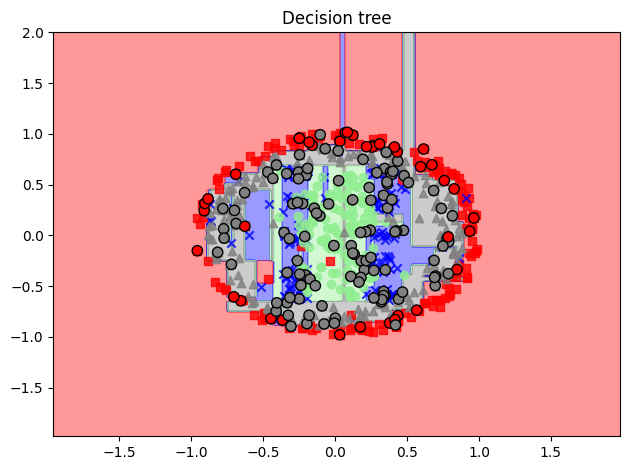

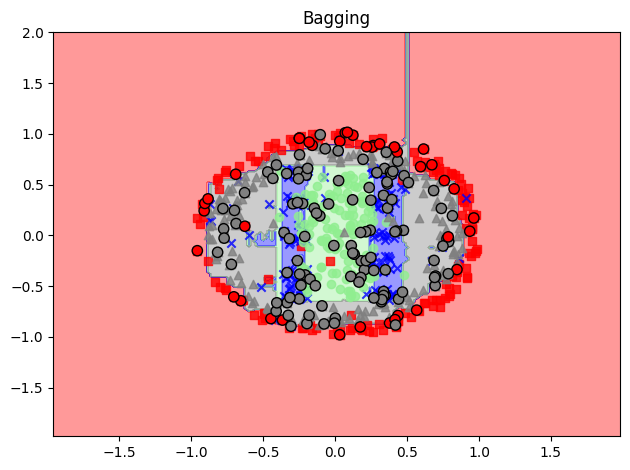

In [6]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()


plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=bag, 
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Bagging')
plt.tight_layout()
plt.show()

### AdaBoost

In [7]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# single decision tree with depth 1
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (tree_train, tree_test))

# adaboost
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (ada_train, ada_test))

[DecisionTree] Train Accuracy = 0.375, Test Accuracy = 0.331

[AdaBoost] Train Accuracy = 0.642, Test Accuracy = 0.486



### GridSearch on AdaBoost

In [8]:
# GridSearch on tree depth for adaboost
tree = DecisionTreeClassifier(criterion='entropy')
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    print('[Outer fold %d/5]' % (i + 1))
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    param_grid = {'base_estimator__max_depth': [1, 3, 5, 7]}
    gs = GridSearchCV(estimator=ada, param_grid=param_grid, scoring='accuracy', cv=inner_cv)
    gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    best_clf.fit(X_train, y_train)    
    outer_scores.append(best_clf.score(X_test, y_test))
    print('Test accuracy: %.2f (depth=%d selected by inner 10-fold CV)' % 
                  (outer_scores[i], gs.best_params_['base_estimator__max_depth']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]


Test accuracy: 0.82 (depth=7 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.82 (depth=5 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.78 (depth=7 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.84 (depth=7 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 0.82 (depth=7 selected by inner 10-fold CV)

Test accuracy: 0.82 (5x10 nested CV)


In [9]:
print("Re-train AdaBoost with best depth 7")
tree = DecisionTreeClassifier(criterion='entropy', max_depth=7)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('[DecisionTree] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (tree_train, tree_test))

ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (ada_train, ada_test))

Re-train AdaBoost with best depth 7
[DecisionTree] Train Accuracy = 0.900, Test Accuracy = 0.789



[AdaBoost] Train Accuracy = 1.000, Test Accuracy = 0.823



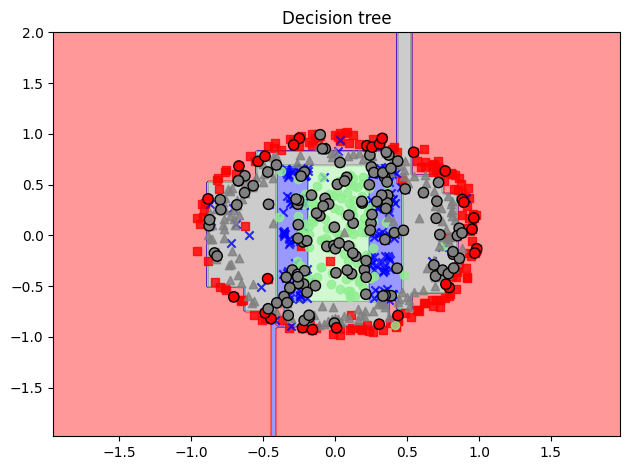

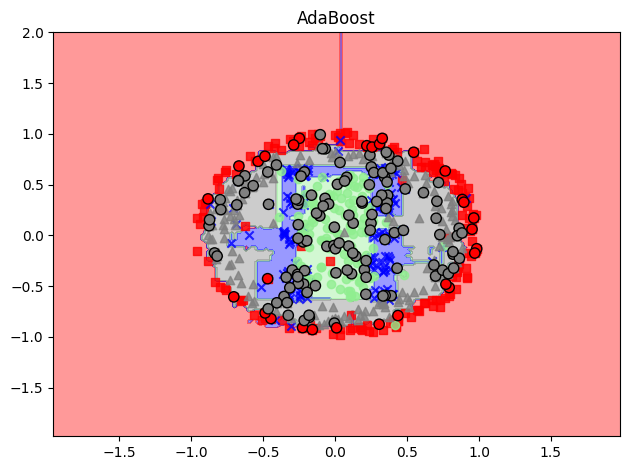

In [10]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=tree,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.show()

plot_decision_regions(X=X_combined, y=y_combined, 
                      classifier=ada,
                      test_idx=range(len(y_train), 
                                     len(y_train) + len(y_test)))
plt.title('AdaBoost')
plt.tight_layout()
plt.show()

### Compare Result

In [12]:
# Voting
voting = VotingClassifier(estimators=[
                          ('dt', dt),
                          ('knn', knn), 
                          ('svc', svc)], 
                          voting='soft', 
                          weights=[0,1,2])
voting.fit(X_train, y_train)
y_train_pred = voting.predict(X_train)
y_test_pred = voting.predict(X_test)
voting_train = accuracy_score(y_train, y_train_pred)
voting_test = accuracy_score(y_test, y_test_pred)
print('[Voting] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (voting_train, voting_test))

# Bagging
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, 
                        max_samples=0.7, bootstrap=True,
                        max_features=1.0, bootstrap_features=False, 
                        n_jobs=1, random_state=1)
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('[Bagging] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (bag_train, bag_test))

# Adaboost with max_depth 7
tree = DecisionTreeClassifier(criterion='entropy', max_depth=7)
tree = tree.fit(X_train, y_train)

ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500)
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('[AdaBoost-7] Train Accuracy = %.3f, Test Accuracy = %.3f\n' % (ada_train, ada_test))

[Voting] Train Accuracy = 0.856, Test Accuracy = 0.844

[Bagging] Train Accuracy = 0.905, Test Accuracy = 0.816

[AdaBoost-7] Train Accuracy = 1.000, Test Accuracy = 0.830



### Summary

最後的結果中，使用了KNN加上SVC的Voting model表現比Bagging和AdaBoost還要好上一些，而AdaBoost with max_depth 7在train的accuracy有到達1.0，代表有overfitting的現象出現，若是針對其他除max_depth的參數再做Grid Search有機會可以使其表現超過voting，但因時間有限就未繼續嘗試。